In [2]:
from keras.models import Sequential, Model
from keras.layers import TimeDistributed,RepeatVector, LSTM, Dense
from keras import regularizers
import numpy as np
import tables as tb

In [50]:
# create the unsupervised learning model
l2=0.01
n_lstm_units=10
dim=151
n_back=21
n_subs=20

model = Sequential()
model.add(LSTM(n_lstm_units,activation='relu',input_shape=(n_back,dim),kernel_regularizer=regularizers.L2(l2=l2), activity_regularizer=regularizers.L2(l2)))
model.add(RepeatVector(n_back))
model.add(LSTM(n_lstm_units,activation='relu',return_sequences=True,kernel_regularizer=regularizers.L2(l2=l2), activity_regularizer=regularizers.L2(l2)))
model.add(TimeDistributed(Dense(dim)))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10)                6480      
                                                                 
 repeat_vector_6 (RepeatVect  (None, 21, 10)           0         
 or)                                                             
                                                                 
 lstm_13 (LSTM)              (None, 21, 10)            840       
                                                                 
 time_distributed_5 (TimeDis  (None, 21, 151)          1661      
 tributed)                                                       
                                                                 
Total params: 8,981
Trainable params: 8,981
Non-trainable params: 0
_________________________________________________________________


In [9]:
import scipy.io as sio
filename='../data/curated_bold.mat'
data=sio.loadmat(filename)
data['roiEpochs'].shape

(3, 20, 151, 621)

In [76]:
bold_4d=data['roiEpochs']
bad_subs=np.array([0,4,13])
good_subs = np.setdiff1d(np.arange(n_subs),bad_subs)
e_bold = np.squeeze(bold_4d[0,good_subs,:,:])
np.mean(np.isnan(e_bold))
e_bold[np.isnan(e_bold)]=0
np.mean(np.isnan(e_bold))

0.0

In [77]:
n_wins = e_bold.shape[2]-n_back
print(n_wins)

600


In [78]:
tpl_bold = np.nan * np.ones(shape=(e_bold.shape[0],e_bold.shape[1],n_back,n_wins))
for s in np.arange(e_bold.shape[0]):
    for w in np.arange(n_wins):
        tpl_bold[s,:,:,w]=np.squeeze(e_bold[s,:,np.arange(w,w+n_back)]).T

In [79]:
tpl_bold = np.swapaxes(tpl_bold,1,3)

In [80]:
tpl_bold=np.reshape(tpl_bold,(tpl_bold.shape[0]*tpl_bold.shape[1],tpl_bold.shape[2],tpl_bold.shape[3]))

In [81]:
np.mean(np.isnan(tpl_bold))

0.0

In [82]:
model.fit(tpl_bold,tpl_bold, epochs=10, verbose=1)

Epoch 1/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0895
Epoch 2/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0886
Epoch 3/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0881
Epoch 4/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0877
Epoch 5/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0874
Epoch 6/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0870
Epoch 7/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0868
Epoch 8/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0865
Epoch 9/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0863
Epoch 10/10
319/319 [==============================] - 3s 9ms/step - loss: 0.0860


In [83]:
encoder = Model(inputs=model.inputs, outputs=model.layers[0].output)

In [84]:
encoded_data=encoder.predict(tpl_bold)

In [85]:
encoded_data = np.reshape(encoded_data,(17,600,encoded_data.shape[1]))

In [86]:
tmp = np.squeeze(np.mean(encoded_data,0))

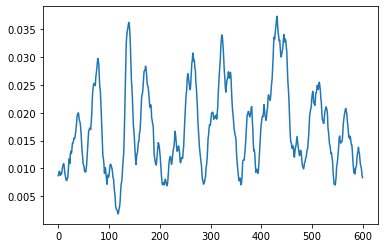

In [97]:
import matplotlib.pyplot as plt
plt.plot(tmp[:,6])
plt.show()